<p align="center">
    <h1 style="text-align: center;">Predicting Video Game Global Sales</h1>
    <h3 style="text-align: center;">Vijay Lemon</h3>
    <h3 style="text-align: center;">ITCS3156 Final Project</h3>
</p>

### Utils

In [ ]:
from typing import List, Dict, Tuple, Callable
import os
import gc
import traceback
import warnings
from pdb import set_trace

import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings("ignore")


Import dataset

In [19]:
df = pd.read_csv("video games sales.csv")
df.dropna(subset=["Year", "Global_Sales"], inplace=True)
df["Year"] = df["Year"].astype(int)
df.drop(columns=["Name", "Rank"], inplace=True)

categorical_cols = ["Platform", "Genre", "Publisher"]
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

bool_cols = df_encoded.select_dtypes(include=["bool"]).columns
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)

numerical_cols = ["Year", "Global_Sales"]
scaler = StandardScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

display(df)
df.describe()

display(df_encoded)
df_encoded.describe()

,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
...,...,...,...,...,...,...,...,...,...
16593,GBA,2002,Platform,Kemco,0.01,0.00,0.00,0.00,0.01
16594,GC,2003,Shooter,Infogrames,0.01,0.00,0.00,0.00,0.01
16595,PS2,2008,Racing,Activision,0.00,0.00,0.00,0.00,0.01
16596,DS,2010,Puzzle,7G//AMES,0.00,0.01,0.00,0.00,0.01


,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Platform_3DO,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,Platform_GEN,Platform_GG,Platform_N64,Platform_NES,Platform_NG,Platform_PC,Platform_PCFX,Platform_PS,Platform_PS2,Platform_PS3,Platform_PS4,Platform_PSP,Platform_PSV,Platform_SAT,Platform_SCD,Platform_SNES,Platform_TG16,Platform_WS,Platform_Wii,Platform_WiiU,Platform_X360,Platform_XB,Platform_XOne,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Platform,...,Publisher_Victor Interactive,Publisher_Video System,Publisher_Views,Publisher_Vir2L Studios,Publisher_Virgin Interactive,Publisher_Virtual Play Games,Publisher_Visco,Publisher_Vivendi Games,Publisher_Wanadoo,Publisher_Warashi,Publisher_Wargaming.net,Publisher_Warner Bros. Interactive Entertainment,Publisher_Warp,Publisher_WayForward Technologies,Publisher_Westwood Studios,Publisher_White Park Bay Software,Publisher_Wizard Video Games,Publisher_XS Games,Publisher_Xicat Interactive,Publisher_Xing Entertainment,Publisher_Xplosiv,Publisher_Xseed Games,Publisher_Yacht Club Games,Publisher_Yamasa Entertainment,Publisher_Yeti,Publisher_Yuke's,Publisher_Yumedia,Publisher_Zenrin,Publisher_Zoo Digital Publishing,Publisher_Zoo Games,Publisher_Zushi Games,Publisher_bitComposer Games,Publisher_dramatic create,Publisher_fonfun,Publisher_iWin,Publisher_id Software,Publisher_imageepoch Inc.,Publisher_inXile Entertainment,"Publisher_mixi, Inc",Publisher_responDESIGN
0,-0.069730,41.49,29.02,3.77,8.46,52.500870,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-3.672528,29.08,3.58,6.81,0.77,25.356183,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.273393,15.85,12.88,3.79,3.31,22.533136,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.444955,15.75,11.01,3.28,2.96,20.732006,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-1.785348,11.27,8.89,10.22,1.00,19.690927,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16593,-0.755977,0.01,0.00,0.00,0.00,-0.338658,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16594,-0.584416,0.01,0.00,0.00,0.00,-0.338658,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16595,0.273393,0.00,0.00,0.00,0.00,-0.338658,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16596,0.616517,0.00,0.01,0.00,0.00,-0.338658,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Platform_3DO,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,Platform_GEN,Platform_GG,Platform_N64,Platform_NES,Platform_NG,Platform_PC,Platform_PCFX,Platform_PS,Platform_PS2,Platform_PS3,Platform_PS4,Platform_PSP,Platform_PSV,Platform_SAT,Platform_SCD,Platform_SNES,Platform_TG16,Platform_WS,Platform_Wii,Platform_WiiU,Platform_X360,Platform_XB,Platform_XOne,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Platform,...,Publisher_Victor Interactive,Publisher_Video System,Publisher_Views,Publisher_Vir2L Studios,Publisher_Virgin Interactive,Publisher_Virtual Play Games,Publisher_Visco,Publisher_Vivendi Games,Publisher_Wanadoo,Publisher_Warashi,Publisher_Wargaming.net,Publisher_Warner Bros. Interactive Entertainment,Publisher_Warp,Publisher_WayForward Technologies,Publisher_Westwood Studios,Publisher_White Park Bay Software,Publisher_Wizard Video Games,Publisher_XS Games,Publisher_Xicat Interactive,Publisher_Xing Entertainment,Publisher_Xplosiv,Publisher_Xseed Games,Publisher_Yacht Club Games,Publisher_Yamasa Entertainment,Publisher_Yeti,Publisher_Yuke's,Publisher_Yumedia,Publisher_Zenrin,Publisher_Zoo Digital Publishing,Publisher_Zoo Games,Publisher_Zushi Games,Publisher_bitComposer Games,Publisher_dramatic create,Publisher_fonfun,Publisher_iWin,Publisher_id Software,Publisher_imageepoch Inc.,Publisher_inXile Entertainment,"Publisher_mixi, Inc",Publisher_responDESIGN
count,1.632700e+04,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,...,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000
mean,1.781166e-14,0.265415,0.147554,0.078661,0.048325,0.000000,0.000184,0.030624,0.003185,0.130642,0.005941,0.049672,0.033197,0.001654,0.000061,0.019354,0.006002,0.000735,0.057757,0.000061,0.072824,0.130275,0.079868,0.020579,0.073314,0.025234,0.010596,0.000367,0.014638,0.000122,0.000367,0.079010,0.008758,0.075642,0.049182,0.013046,0.078153,0.051204,0.104734,0.053653,...,0.000551,0.000245,0.000122,0.000184,0.003797,0.000122,0.000061,0.009861,0.000306,0.000061,0.000061,0.013291,0.000061,0.000061,0.000061,0.000061,0.000061,0.000735,0.000184,0.000061,0.000612,0.000245,0.000184,0.000122,0.000674,0.000184,0.000061,0.000122,0.006370,0.002021,0.001102,0.000306,0.000306,0.000061,0.000061,0.000061,0.000122,0.000061,0.000061,0.000122
std,1.000031e+00,0.821591,0.508766,0.311557,0.189885,1.000031,0.013554,0.172302,0.056347,0.337019,0.076851,0.217274,0.179155,0.040633,0.007826,0.137772,0.077244,0.027101,0.233291,0.007826,0.259856,0.336616,0.271097,0.141976,0.260659,0.156841,0.102393,0.019167,0.120104,0.011067,0.019167,0.269763,0.093179,0.264432,0.216255,0.113475,0.268420,0.220419,0.306220,0.225339,...,0.023473,0.015651,0.011067,0.013554,0.061508,0.011067,0.007826,0.098815,0.017498,0.007826,0.007826,0.114521,0.007826,0.007826,0.007826,0.007826,0.007826,0.027101,0.013554,0.007826,0.024742,0.015651,0.013554,0.011067,0.025948,0.013554,0.007826,0.011067,0.079559,0.044914,0.033186,0.017498,0.017498,0.007826,0.007826,0.007826,0.011067,0.007826,0.007826,0.011067
min,-4.530338e+0

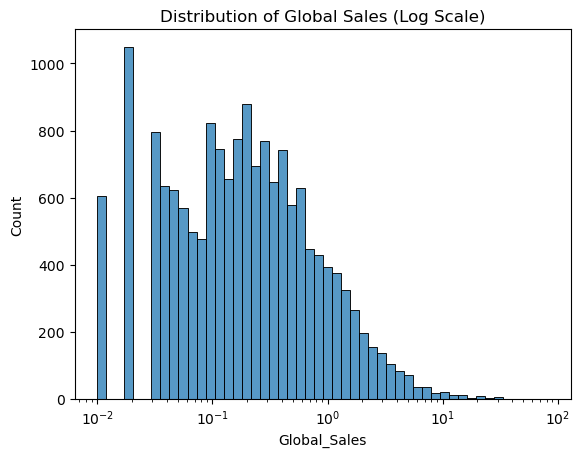

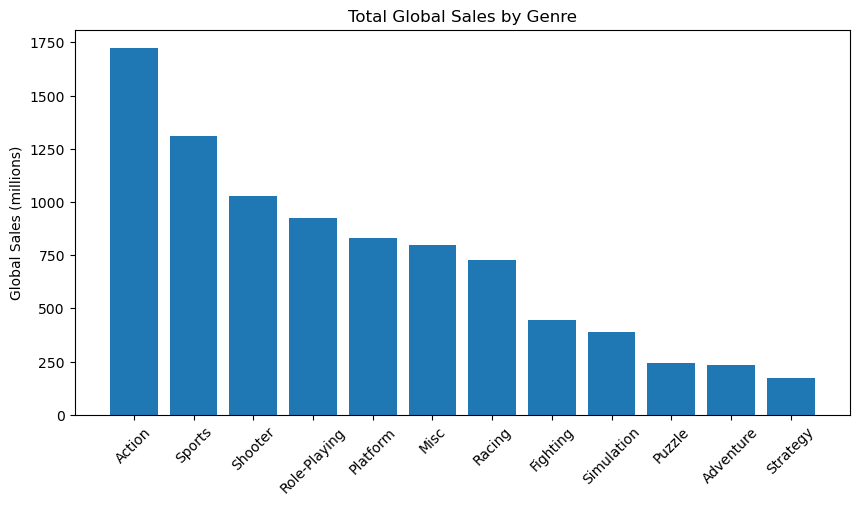

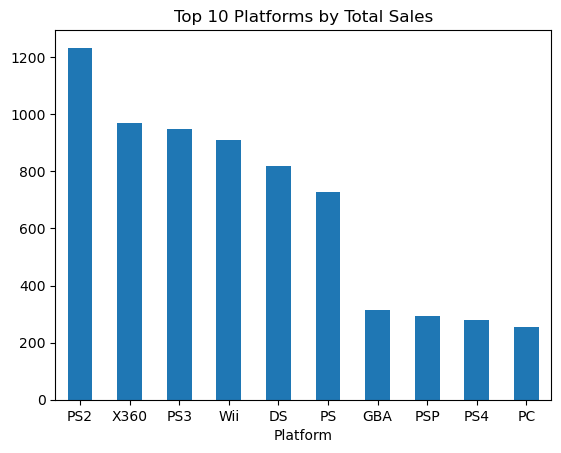

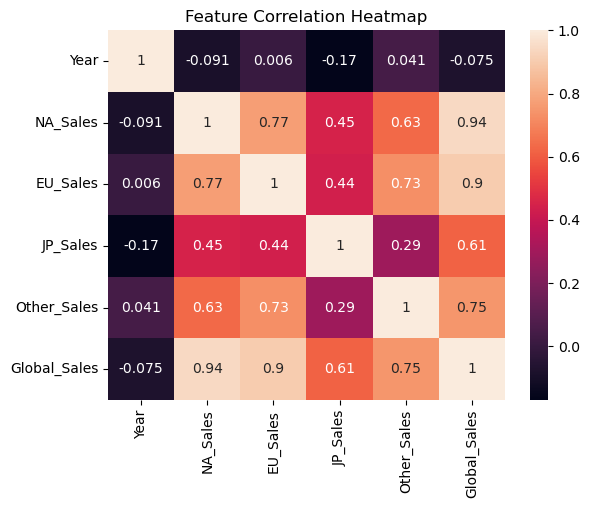

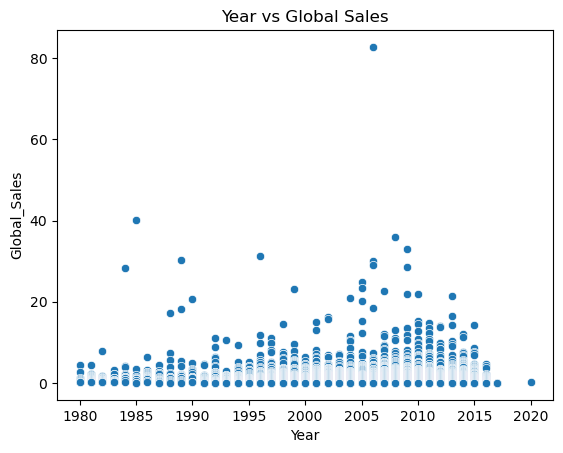

In [3]:
# Check distributions
plt.figure()
sns.histplot(df["Global_Sales"], bins=50, log_scale=True)
plt.title("Distribution of Global Sales (Log Scale)")
plt.show()

# Sales by Genre
genre_totals = df.groupby("Genre")["Global_Sales"].sum().sort_values(ascending=False).reset_index()
plt.figure(figsize=(10,5))
plt.bar(genre_totals["Genre"], genre_totals["Global_Sales"])
plt.xticks(rotation=45)
plt.title("Total Global Sales by Genre")
plt.ylabel("Global Sales (millions)")
plt.show()

# Sales by Platform (Top 10)
top_platforms = df.groupby("Platform")["Global_Sales"].sum().sort_values(ascending=False).head(10)
plt.figure()
top_platforms.plot(kind="bar")
plt.xticks(rotation=0)
plt.title("Top 10 Platforms by Total Sales")
plt.show()

# Correlation heatmap (only numeric)
plt.figure()
sns.heatmap(df.select_dtypes(np.number).corr(), annot=True)
plt.title("Feature Correlation Heatmap")
plt.show()

# Year vs Global Sales
plt.figure()
sns.scatterplot(x="Year", y="Global_Sales", data=df)
plt.title("Year vs Global Sales")
plt.show()

In [20]:
summary = df.groupby("Genre")["Global_Sales"].sum().sort_values(ascending=False)
print(summary.to_string())

top_platforms = (df.groupby("Platform")["Global_Sales"].sum().sort_values(ascending=False).head(10))
print("\nTop 10 Platforms by Total Global Sales:\n")
print(top_platforms.to_string())

numeric_corr = df.select_dtypes(include="number").corr()
print("\nCorrelation Matrix (Numeric Features):\n")
print(numeric_corr.to_string())

year_sales = (df.groupby("Year")["Global_Sales"].sum().sort_index())

print("\nTotal Global Sales per Year:\n")
print(year_sales.to_string())



Genre
Action          1722.88
Sports          1309.24
Shooter         1026.20
Role-Playing     923.84
Platform         829.15
Misc             797.62
Racing           726.77
Fighting         444.05
Simulation       390.16
Puzzle           242.22
Adventure        234.80
Strategy         173.43

Top 10 Platforms by Total Global Sales:

Platform
PS2     1233.46
X360     969.61
PS3      949.35
Wii      909.81
DS       818.96
PS       727.39
GBA      313.56
PSP      291.71
PS4      278.10
PC       255.05

Correlation Matrix (Numeric Features):

                  Year  NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales
Year          1.000000 -0.091402  0.006014 -0.169316     0.041058     -0.074735
NA_Sales     -0.091402  1.000000  0.768936  0.451285     0.634508      0.941268
EU_Sales      0.006014  0.768936  1.000000  0.436414     0.726266      0.903271
JP_Sales     -0.169316  0.451285  0.436414  1.000000     0.290653      0.612794
Other_Sales   0.041058  0.634508  0.726266  0.290653  

In [21]:
# Separate features and target
X = df_encoded.drop(columns=["Global_Sales"]).values
y = df_encoded["Global_Sales"].values

# Split data into 3 ways: Train -> Validation -> Test
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)
X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, train_size=0.8, test_size=0.2, random_state=42)

In [22]:
# Ridge Regression
X_trn_scaled = scaler.fit_transform(X_trn)
X_vld_scaled = scaler.transform(X_vld)
X_tst_scaled = scaler.transform(X_tst)

# Train Ridge
ridge = Ridge(alpha=10.0)
ridge.fit(X_trn_scaled, y_trn)

# Predict on scaled sets
y_vld_ridge = ridge.predict(X_vld_scaled)
y_tst_ridge = ridge.predict(X_tst_scaled)

# Evaluate Ridge Regression
mse_ridge_vld = mean_squared_error(y_vld, y_vld_ridge)
mse_ridge_tst = mean_squared_error(y_tst, y_tst_ridge)

r2_ridge_vld = r2_score(y_vld, y_vld_ridge)
r2_ridge_tst = r2_score(y_tst, y_tst_ridge)

print("Validation MSE:", mse_ridge_vld)
print("Validation R^2:", r2_ridge_vld)
print("Test MSE:", mse_ridge_tst)
print("Test R^2:", r2_ridge_tst)

Validation MSE: 1.1474346868351288e-05
Validation R^2: 0.9999869406434416
Test MSE: 1.2087732875355776e-05
Test R^2: 0.9999930646736572


In [23]:
# k-NN Regression

X_trn_scaled = scaler.fit_transform(X_trn)
X_vld_scaled = scaler.transform(X_vld)
X_tst_scaled = scaler.transform(X_tst)

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_trn_scaled, y_trn)

y_vld_knn = knn.predict(X_vld_scaled)
y_tst_knn = knn.predict(X_tst_scaled)

mse_knn_vld = mean_squared_error(y_vld, y_vld_knn)
mse_knn_tst = mean_squared_error(y_tst, y_tst_knn)

r2_knn_vld = r2_score(y_vld, y_vld_knn)
r2_knn_tst = r2_score(y_tst, y_tst_knn)

print("Validation MSE:", mse_knn_vld)
print("Validation R^2:", r2_knn_vld)
print("Test MSE:", mse_knn_tst)
print("Test R^2:", r2_knn_tst)

Validation MSE: 0.17308697404556597
Validation R^2: 0.8030036449470084
Test MSE: 0.49973397661146424
Test R^2: 0.7132780606482645


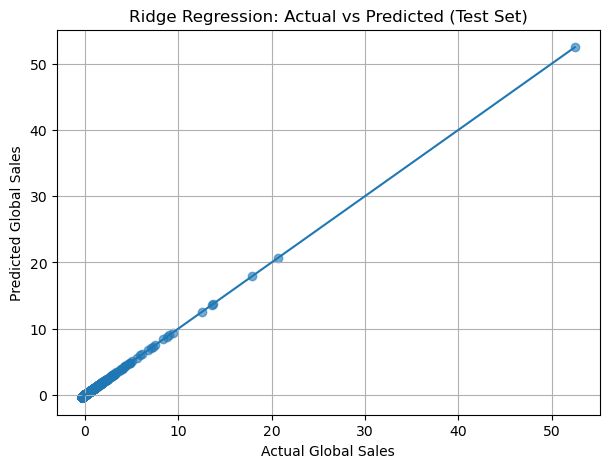

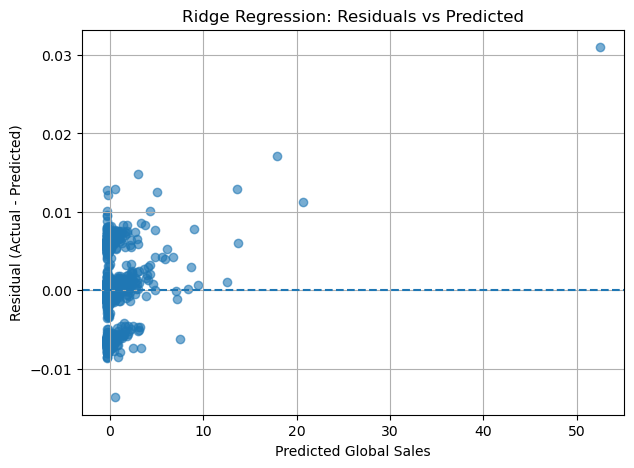

In [24]:
# 1. Predicted vs Actual
plt.figure(figsize=(7, 5))
plt.scatter(y_tst, y_tst_ridge, alpha=0.6)
plt.plot([y_tst.min(), y_tst.max()], [y_tst.min(), y_tst.max()])
plt.xlabel("Actual Global Sales")
plt.ylabel("Predicted Global Sales")
plt.title("Ridge Regression: Actual vs Predicted (Test Set)")
plt.grid(True)
plt.show()

# 2. Residual Plot
ridge_residuals = y_tst - y_tst_ridge

plt.figure(figsize=(7, 5))
plt.scatter(y_tst_ridge, ridge_residuals, alpha=0.6)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted Global Sales")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Ridge Regression: Residuals vs Predicted")
plt.grid(True)
plt.show()

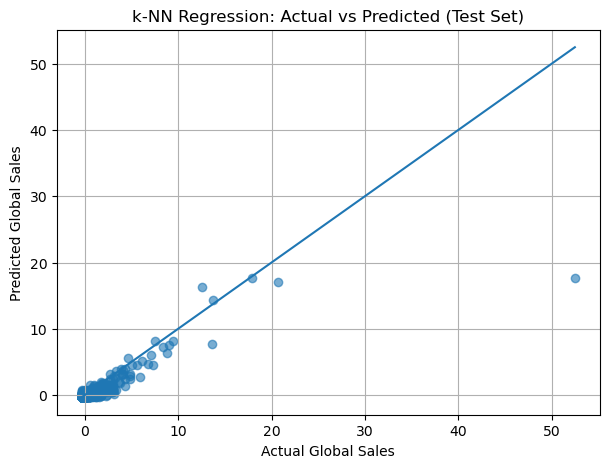

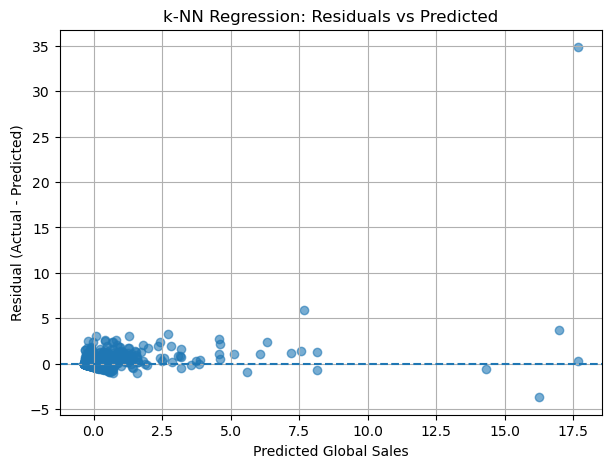

In [25]:
# 1. Predicted vs Actual
plt.figure(figsize=(7, 5))
plt.scatter(y_tst, y_tst_knn, alpha=0.6)
plt.plot([y_tst.min(), y_tst.max()], [y_tst.min(), y_tst.max()])
plt.xlabel("Actual Global Sales")
plt.ylabel("Predicted Global Sales")
plt.title("k-NN Regression: Actual vs Predicted (Test Set)")
plt.grid(True)
plt.show()

# 2. Residual Plot
knn_residuals = y_tst - y_tst_knn

plt.figure(figsize=(7, 5))
plt.scatter(y_tst_knn, knn_residuals, alpha=0.6)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted Global Sales")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("k-NN Regression: Residuals vs Predicted")
plt.grid(True)
plt.show()